In [1]:
import pandas as pd
import glob
import datetime as datetime
from datetime import timedelta
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import os
from scipy.integrate import quad
import sys
from scipy.optimize import leastsq
from jupyterthemes import jtplot
jtplot.reset()

In [2]:
df_modtran = pd.read_csv('DWD_code_data/MODTRAN.csv')

df_solpos = pd.read_csv('DWD_code_data/sol_pos.csv')
df_solpos['DateTime'] = pd.to_datetime(df_solpos['DateTime']) 


df_DWD = pd.read_csv('DWD_code_data/DWD_final_data.csv')
df_DWD['DateTime'] = pd.to_datetime(df_DWD['DateTime'])

df_ozone = pd.read_csv('DWD_code_data/ozone.csv')
df_ozone['DateTime'] = pd.to_datetime(df_ozone['DateTime'])

df_blank = pd.read_csv('DWD_code_data/blank_image_data.csv')
mask = pd.read_csv('contour_new.csv')
raa = pd.read_csv('DWD_code_data/azimuth.csv')['raa'].values
# df_look_up = pd.read_csv('DWD_code_data/look_up.csv')
df_look_up = pd.read_csv('DWD_code_data/look_up.csv')

azimuth = pd.read_csv('DWD_code_data/azimuth.csv')

In [3]:
pd.read_csv('DWD_code_data/azimuth.csv')['raa']

0         234.707944
1         234.626399
2         234.544526
3         234.462322
4         234.379787
             ...    
307195     51.156183
307196     51.248372
307197     51.340192
307198     51.431645
307199     51.522734
Name: raa, Length: 307200, dtype: float64

In [4]:
############################
# Function to extract timestamp of single image from its name
def im_timestamp_sig(files15):
    import datetime as datetime
    s = files15[31:44]
    t = datetime.datetime.strptime(s, '%y%m%d_%H%M%S') 
    return t

############################
# Function to extract timestamp of all the image from its name
def im_timestamp(files15):
    dt = []
    for i in range(0,len(files15)):
        s = files15[i][31:37]
        ss = files15[i][38:44]
        t = ':'.join(a+b for a,b in zip(ss[::2], ss[1::2]))
        d = '/'.join(a+b for a,b in zip(s[::2], s[1::2]))
        d_t = d +','+ t
        dt.append(d_t)
    Time = []
    for i in range(0,len(dt)):
        date_dt = datetime.datetime.strptime(dt[i], '%y/%m/%d,%H:%M:%S')
        Time.append(date_dt.strftime("%Y-%m-%d %H:%M:%S"))    
    return Time
###########################
### Function to extract the CWV,AOD,ozone,sza.
# To use this function, you just need to input:
# ((df: which is the timestamp of single image (Not in dataframe but in datetime format)))
# ((df_: is the dataframe from which you want to extract the meteriological data))
## It is important that the df_ has a datetime column with data type of ""datetime64[ns]""
def find_para_sig(df,df_):
    def nearest(items, pivot):
        return min(items, key=lambda x: abs(x - pivot))
    
    tmstp = nearest(df_['DateTime'][:],df)
    val = df_.loc[df_.DateTime == tmstp]
    
    return val
### Function to extract the CWV,AOD,ozone,sza.
# To use this function, you just need to input:
# ((df: which is image timestamp dataframe))
# ((df_: is the dataframe from which you want to extract the meteriological data))
## It is important that the df_ has a datetime column with data type of ""datetime64[ns]""

def find_para(df,df_,k):
    def nearest(items, pivot):
        return min(items, key=lambda x: abs(x - pivot))
    
    tmstp = nearest(df_['DateTime'][:],df['DateTime'][k])
    val = df_.loc[df_.DateTime == tmstp]
    
    return val

##############################
### The function performs the clockwise rotation of the vector. 
## Input: vector a, eg. a = np.array([a1,a2])
#         angle in deg, eg. a = 45

# Output: Final rotated vector
def rot(a , ang):
    theta = ang*np.pi/180
    R = np.array([[np.cos(theta) , -np.sin(theta)],\
                [np.sin(theta), np.cos(theta)]])
    
    b1 = R[0,0]*a[0] + R[0,1]*a[1]
    b2 = R[1,0]*a[0] + R[1,1]*a[1]
    b = [b1 , b2]
    
    return b
###############################
## This function performs the search for the nearest value in an array
# Input: 1. array from which the search has to be performed
#        2. Value which needs to be searched in an array

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

###############################
## This function get the radiance from MODTRAN look-up table, 
## based on the input parameters
## Input: 
#         1. dataset = df_modtran
#         2. sza,aot,cwv,oz are metereological data obtained from DWD

def find_instant_rad(dataset,sza,aot,cwv,oz):
    val = dataset.values
    # find_nearest(val[:,0],40.345)
    # gr1 = dataset
    gr1 = dataset[dataset['sza'] == find_nearest(val[:,1],sza[0])]
    val2 = gr1.values
    gr2 = gr1[gr1['aot'] == find_nearest(val2[:,3],aot[0])]
    #gr2 = gr[gr['aot'] == find_nearest(val[:,3],0.37)]
    val3 = gr2.values
    gr3 = gr2[gr2['cwv'] == find_nearest(val3[:,4],cwv[0])]
    val4 = gr3.values
    gr4 = gr3[gr3['oz'] == find_nearest(val3[:,5],oz[0])]
    
    return gr4

###############################
## This function perfroms the radiance interpolation along the viewing
# zenith angle(0-90).
# Input: 1. rad_ is the obtained from **find_instant_rad(val,dataset,sza,aot,cwv,oz)**
#        2. theta = np.arange(0,90,90/200), dividing by 200 because from center we are 
#           considering upto 200 pxls each side
def vza_interpolation(rad_,theta):

    r_az = []
    rang = np.arange(0,100,10)
    for i in rang:
        r = rad_.loc[rad_['vza'] == i, 'amb_rad'].values
#         r = rad[rad[:,0] == 10][:,9]
        r_az.append(r)
#         print(np.shape(r_az))
    y_data = np.array(r_az)

    y_data_0 = y_data[:,0]
    y_data_90 = y_data[:,1]
    
    y_data_180 = y_data[:,2]
    y_data_270 = y_data[:,3]
    
    from scipy.interpolate import UnivariateSpline

    x_data = np.arange(0,100,10)

    spl_0 = UnivariateSpline(x_data,y_data_0[:])
    spl_0.set_smoothing_factor(0.0)

    spl_90 = UnivariateSpline(x_data,y_data_90[:])
    spl_90.set_smoothing_factor(0.0)

    spl_180 = UnivariateSpline(x_data,y_data_180[:])
    spl_180.set_smoothing_factor(0.0)

    spl_270 = UnivariateSpline(x_data,y_data_270[:])
    spl_270.set_smoothing_factor(0.0)
    
    fit_vza = np.vstack((spl_0(theta),spl_90(theta),spl_180(theta),spl_270(theta))).T
    
    return fit_vza


###############################
## This function performs the interpolation along the azimuth angle(0,360)
# Input: 1. vza_int: From vza_interpolation function
#        2. radius = radius or distance of pxls from the center
# Output: The output gives the fitted function, which can later be used for any 
#  input of azimuth angle. eg. sol = spl_(vza_int,radius,w)
#                              rad = sol[raa = 180], raa = relative animuth angle
# def spl_(vza_int,radius,w):
#     r = radius
#     from scipy.interpolate import UnivariateSpline
    
#     x = np.arange(0,450,90)
#     y = np.hstack((vza_int[r-1,:],vza_int[r-1,0]))
#     spl_ = UnivariateSpline(x,y)
    
#     return spl_

def spl_(vza_int,radius,w):
    r = radius
    from scipy.interpolate import UnivariateSpline
    x = np.arange(0,360,90)
#     print(x)
    y = np.hstack((vza_int[r-1,:]))
#     print(y)
    spl_ = UnivariateSpline(x,y)
    return spl_
################################
# This function creates the grid on an image to represent vza and raa on an image. 
# Input: 1. image, on which the grid needs to be created
#        2. dist = radius( 235 for IR and 240 for color)
#        3. number of steps in azimuth direction, eg, steps = 12, then the lines 
#           will be created at an interval of 30deg
#        4. viewing zenith angle
#        5. vza_step, same as az_step
#        6. center of an image. In out case the center is at [332,235]

def image_grid(image,dist,az_step,vza,vza_step,center):
    rotation = np.arange(0,360,360/az_step)
    arr = np.empty((1,2))
    for j in range(center[1],center[1]+dist):
        a = [j]
        b = np.vstack((center[0],a)).T
        arr = np.append(arr,b,axis = 0)
    
    inp = arr[1:,:]
    
    pxl = np.empty((1,2))
    
    for j in rotation:
        vec = [inp[-1][0] - center[0], center[1]- inp[-1][1]]
        p1 = np.around(rot(vec,j))
        p_1 = np.vstack((p1[0] + center[0] , center[1] - p1[1] )).T
        pxl = np.append(pxl ,p_1,axis = 0)
        
    grid = pxl[1:]   
    cir = np.arange(0,dist,dist/vza_step)
    font = cv.FONT_ITALIC 
    
    grid = pxl[1:]
# print(grid)
    for i in cir:
    #         print(i)
        cv.circle(image,(center[0],center[1]),int(i),255)
        for j in range(0,len(inp[0::int(dist/vza_step)])):
            cv.putText(image,str(int(vza[0::int(dist/vza_step)][j])), \
                       (int(inp[0::int(dist/vza_step)][j,0]),\
                        int(inp[0::int(dist/vza_step)][j,1])), font,\
                        0.8, (255,0,0), 2, cv.LINE_AA)

        for j in range(0,len(grid)):
            cv.line(image,(center[0],center[1]),(int(grid[j,0]),int(grid[j,1])),255,1)
            cv.putText(image,str(int(rotation[j])), (int(grid[j,0]),int(grid[j,1])), font,\
                                    0.8, (255), 2, cv.LINE_AA)
    return image



##########################################

# ('DWD_code_data/Test_Image_08/IrImage_200812_1751_-50_+20_0-05_0-8.jpg')
### Below time function is created to extract the timestamp of test images
def test_timestamp_sig(files):
#     files[1][36:42]
    s = files[36:42]
    ss = files[43:47]
    t = ':'.join(a+b for a,b in zip(ss[::2], ss[1::2]))
    d = '-'.join(a+b for a,b in zip(s[::2], s[1::2]))
    d_t = datetime.datetime.strptime(d +' '+ t, '%y-%m-%d %H:%M') 
    return d_t
############################################
##########################################
def test_timestamp_sig(files):
#     files[1][36:42]
    s = files[36:42]
    ss = files[43:47]
    t = ':'.join(a+b for a,b in zip(ss[::2], ss[1::2]))
    d = '-'.join(a+b for a,b in zip(s[::2], s[1::2]))
    d_t = datetime.datetime.strptime(d +' '+ t, '%y-%m-%d %H:%M') 
    return d_t
########################################
def find_instant_rad(dataset,sza,aot,cwv,oz):
    val = dataset.values
    # find_nearest(val[:,0],40.345)
    # gr1 = dataset
    gr1 = dataset[dataset['sza'] == find_nearest(val[:,1],sza[0])]
    val2 = gr1.values
    gr2 = gr1[gr1['aot'] == find_nearest(val2[:,3],aot[0])]
    #gr2 = gr[gr['aot'] == find_nearest(val[:,3],0.37)]
    val3 = gr2.values
    gr3 = gr2[gr2['cwv'] == find_nearest(val3[:,4],cwv[0])]
    val4 = gr3.values
    gr4 = gr3[gr3['oz'] == find_nearest(val3[:,5],oz[0])]
    
    return gr4
######################################
def vza_interpolation(rad_,theta):

    r_az = []
    rang = np.arange(0,100,10)
    for i in rang:
        r = rad_.loc[rad_['vza'] == i, 'amb_rad'].values
#         r = rad[rad[:,0] == 10][:,9]
        r_az.append(r)
#         print(np.shape(r_az))
    y_data = np.array(r_az)

    y_data_0 = y_data[:,0]
    y_data_90 = y_data[:,1]
    
    y_data_180 = y_data[:,2]
    y_data_270 = y_data[:,3]
    
    from scipy.interpolate import UnivariateSpline

    x_data = np.arange(0,100,10)

    spl_0 = UnivariateSpline(x_data,y_data_0[:])
    spl_0.set_smoothing_factor(0.0)

    spl_90 = UnivariateSpline(x_data,y_data_90[:])
    spl_90.set_smoothing_factor(0.0)

    spl_180 = UnivariateSpline(x_data,y_data_180[:])
    spl_180.set_smoothing_factor(0.0)

    spl_270 = UnivariateSpline(x_data,y_data_270[:])
    spl_270.set_smoothing_factor(0.0)
    
    fit_vza = np.vstack((spl_0(theta),spl_90(theta),spl_180(theta),spl_270(theta))).T
    
    return fit_vza


###############################
# def spl_(vza_int,radius,w):
#     r = radius
#     from scipy.interpolate import UnivariateSpline
    
#     x = np.arange(0,450,90)
#     y = np.hstack((vza_int[r-1,:],vza_int[r-1,0]))
#     spl_ = UnivariateSpline(x,y)
    
#     return spl_
#############################
def find_para_sig(df,df_):
    def nearest(items, pivot):
        return min(items, key=lambda x: abs(x - pivot))
    
    tmstp = nearest(df_['DateTime'][:],df)
    val = df_.loc[df_.DateTime == tmstp]
    
    return val
##########################
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
##########################
## Below function will fetch all the pixels corresponding to the mentioned angle and center
############################################
# input = image, angle = (0,360),theta = np.around(np.arange(0,90,90/230),6)

def pxl(image,angle,center,Tmax,Tmin):
#     center[0] = 332
#     center[1] = 235
#     print(center[0])
#     print(center[1])
    inp = np.vstack((np.full((235,1),center[0])[:,0],\
                   np.arange(center[1],center[1]+235,1))).T ### initial vector from center to 230 pxls. 
    pxl1 = np.zeros((len(inp),2))
    for i in range(0,len(inp)):
        vec = [inp[i,0]-center[0], center[1]-inp[i,1]]

        p1 = np.around(rot(vec,angle))
        pxl1[i,0] = p1[0]+center[0]
        print(pxl1[i,0])
        pxl1[i,1] = p1[1]+center[1]
        print(pxl1[i,1])
    
    Zmax = 255 
    Zmin = 0
    c = Tmin

    m = (Tmax - Tmin) / (Zmax - Zmin)

    T1 = np.array([])
    ang = np.array([])
    for i in range(0,len(pxl1)):
        intensity1 = image[int(pxl1[i,1]),int(pxl1[i,0])]
        r1 = np.around(np.sqrt((center[0] - pxl1[i,0]) ** 2 + (center[1] - pxl1[i,1]) ** 2))

        if r1 < 235:
            t1 = (m*intensity1 + c)+273.3
            k1 = r1 * 90 / 230
        else:
            k1 = 120
            t1 = 30+273.3
        T1 = np.append(T1,t1)
        ang = np.append(ang,k1)

    final = np.vstack((T1,ang)).T
    print('Output has Temp,vza')
    return final


def pxl(image,angle,center,Tmax,Tmin):
    inp = np.vstack((np.full((235,1),center[0])[:,0],\
                   np.arange(center[1],center[1]+235,1))).T ### initial vector from center to 200 pxls. 
    pxl1 = np.zeros((len(inp),2))
    for i in range(0,len(inp)):
        vec = [inp[i,0]-center[0], center[1]-inp[i,1]]
    #     print(vec)
        p1 = np.around(rot(vec,angle))
        pxl1[i,0] = p1[0]+center[0]
        pxl1[i,1] = p1[1]+center[1]
    
    Zmax = 255 
    Zmin = 0
    c = Tmin

    m = (Tmax - Tmin) / (Zmax - Zmin)

    T1 = np.array([])
    ang = np.array([])
    for i in range(0,len(pxl1)):
        intensity1 = image[int(pxl1[i,1]),int(pxl1[i,0])]
        r1 = np.around(np.sqrt((center[0] - pxl1[i,0]) ** 2 + (center[1] - pxl1[i,1]) ** 2))

        if r1 < 235:
            t1 = (m*intensity1 + c)+273.3
            k1 = r1 * 90 / 235
        else:
            k1 = 120
            t1 = 30+273.3
        T1 = np.append(T1,t1)
        ang = np.append(ang,k1)

    final = np.vstack((T1,ang)).T
    print('Output has Temp,vza')
    return final

def image_mask(mod,fillna):
    mask = pd.read_csv('contour_new.csv')
    Z_mod = mod.reshape(-1,1)
    img_mod = pd.DataFrame({'pxl_img_mod':Z_mod[:,0]})
    # df_0 = pd.dataFrame({'pxl:', })
    df_0 = pd.DataFrame(0, index=range(len(df_blank)), columns={'f_pxl_1'})

    masking_mod= pd.merge(img_mod,mask,on = img_mod.index)

    # merged = pd.merge(df_blank, img_df,on = img_df.index)
    
    df_mod_int = masking_mod[masking_mod['contour']< 255]
    dataset_plot_mod = pd.merge(df_mod_int, df_0, how='outer', on=None, \
                                left_index=True, right_index=True, sort=True) 
    # dataset_plot.head()
    df_masked_mod = dataset_plot_mod[['key_0', 'pxl_img_mod','contour']].fillna(fillna)  
    image = np.uint8(df_masked_mod['pxl_img_mod'].values.reshape(480,640))
    return image

In [5]:
# files15

files = 'April2020_Images/Images15_04/20200415_022504_-10+25_IrImage.jpg'
# files = 'April2020_Images/Images22_04/20200422_225542_-10+25_IrImage.jpg'
time = im_timestamp_sig(files)
# print(time)
val_dwd = df_DWD[df_DWD.DateTime == find_nearest(df_DWD['DateTime'],np.datetime64(time))][['CWV','AOD']].values
ozone = df_ozone[df_ozone.DateTime == find_nearest(df_ozone['DateTime'],np.datetime64(time))]['O3_Nearest'].values
sza = df_solpos[df_solpos.DateTime == find_nearest(df_solpos['DateTime'],np.datetime64(time))]['sza'].values
amb_tem = df_DWD[df_DWD.DateTime == find_nearest(df_DWD['DateTime'],np.datetime64(time))][['Amb_Tem']].values
rad_modeled = df_modtran[(df_modtran.aot == find_nearest(df_modtran.aot.values,val_dwd[0,1]))&\
           (df_modtran.cwv == find_nearest(df_modtran.cwv.values,val_dwd[0,0]))&\
           (df_modtran.sza == find_nearest(df_modtran.sza.values,sza))&\
           (df_modtran.oz == find_nearest(df_modtran.oz.values,ozone))&\
           (df_modtran.raa == 90)][['vza','pth_thrml']]

# rad_modeled


surface_temp 259.6046218487395


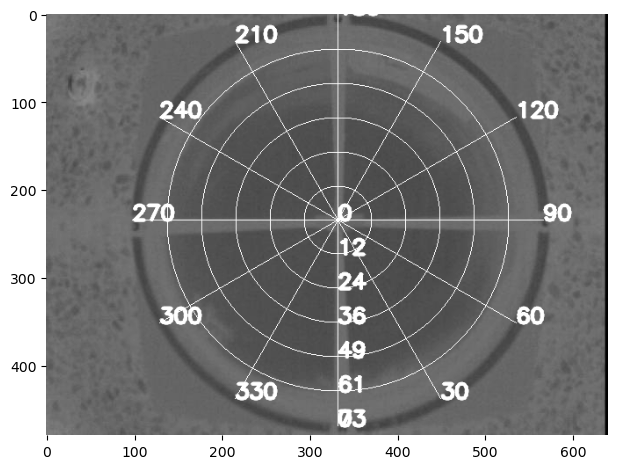

In [6]:
img = cv.imread('April2020_Images/Images15_04/20200415_022504_-10+25_IrImage.jpg',0)

# plt.imshow(img, cmap = 'gray')
# plt.show()

tape = img[231:244,321:349]
Z = tape.reshape(-1,1)

Tmax = 25
Tmin = -40

c = Tmin
m = (Tmax - Tmin)/255
T = np.mean(m*Z + c)


# T = 22+273.3
T = T+273.3
print('surface_temp',T)
def integration(lamda,T):
    h = 6.626e-34
    c = 2.99e8
    k = 1.38e-23
    var = (2*h*c**2/(lamda**5))*(1/(np.exp(h*c/(lamda*k*T)) -1))
    return var

Res = quad(integration,8e-6,14e-6,args = (T))


# L_final = gamma*rad_modeled['pth_thrml'] + psi*Res[0]
gamma = 0.5068241258910146
psi = 0.23268445135994728
rad_modeled['pth_thrml'] = rad_modeled['pth_thrml'].apply(lambda x: (gamma+0.4)*x + (psi+0.2)*Res[0])
# (gamma+0.4)*x + (psi+0.2)
plt.imshow(image_grid(img,235,12,np.arange(0,74,74/235),6,[332,235]),cmap = 'gray')
plt.box()
plt.tight_layout()
plt.show()

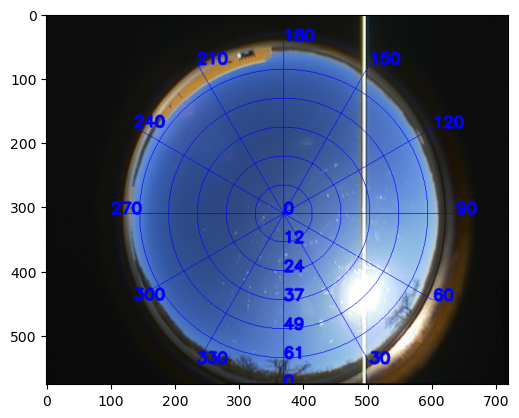

In [12]:
col = cv.imread('April2020_colorimages/Images22_04/20200422_133919_stack.jpg')
xc = 370
yc = 310
plt.imshow(image_grid(col,270,12,np.arange(0,74,74/270),6,[xc,yc])[:,:,::-1])
plt.show()

In [173]:
def brightness_temp(L):

    fit4 = np.array([-7.00668151e-06,  1.34942027e-03, -1.03836055e-01,  5.05728049e+00,
            1.75745362e+02])

    T = np.multiply(fit4[0],np.power(L,4)) +\
                np.multiply(fit4[1],np.power(L,3)) + \
                np.multiply(fit4[2],np.power(L,2)) + \
                np.multiply(fit4[3],np.power(L,1)) + fit4[4]
    return T
rad_modeled['temp'] = rad_modeled['pth_thrml'].apply(brightness_temp)
rad_modeled

vza  pth_thrml        temp
5056     0  22.271803  250.057792
10936   10  22.349983  250.224144
16816   20  22.592190  250.736853
22696   30  23.024787  251.642751
28576   40  23.701538  253.035345
34456   50  24.727893  255.092683
40336   60  26.324181  258.170729
46216   70  29.042671  263.110575
52096   80  34.811456  272.600984
57976   90  55.742711  301.086204

In [174]:
def func(x0,x,T_90):
    return (T_90 - x0[0])*((x/60)**x0[1]) + x0[0]

def residuals(x0, Ydata_cloudy, Xdata_cloudy,T_90):
    return Ydata_cloudy - func(x0,Xdata_cloudy,T_90)

def gen_data(x0,x,T_90):
    return (T_90 - x0[0])*((x/60)**x0[1]) + x0[0]

def smith_fit(data,amb_tem,angle_range):
    if isinstance(data,(pd.core.frame.DataFrame)):   
        Ydata = data['temp'].values
        Xdata = data['vza'].values
        
    elif isinstance(data,(np.ndarray)):
        Ydata = dat[:,1]
        Xdata = data[:,0]
    else:
        raise Exception('wrong type')
        
    T_90 = np.max(Ydata) 
#     T_90 = float(amb_tem[0])+273.3
#     print(T_90)
    x0 = np.array([-6.54181651,2.66781379], dtype = float)
    x_fit, flag_cloudy = leastsq(residuals, x0,\
                                args=(Ydata, Xdata,T_90))
    model_fit = gen_data(x_fit,angle_range,T_90)
    df_modeled = pd.DataFrame({'zenith':angle_range[:],'Temp':model_fit[:]})
    return df_modeled

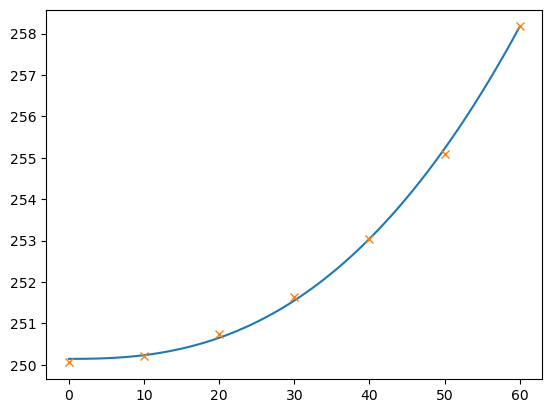

In [175]:
modeled_fit = smith_fit(rad_modeled[rad_modeled['vza'] < 70],amb_tem,np.arange(0,60,60/235))
# modeled_fit = smith_fit(rad_modeled,amb_tem,np.arange(0,90,90/235))
Ydata = modeled_fit[modeled_fit['zenith']<60]['Temp']
Xdata = modeled_fit[modeled_fit['zenith']<60]['zenith']

Ydata = modeled_fit['Temp']
Xdata = modeled_fit['zenith']
# print(Xdata)
# print(modeled_fit)
plt.plot(Xdata,Ydata,label = 'Modeled_Brightness_Temp_fit')
plt.plot(rad_modeled[rad_modeled['vza']<70]['vza'], rad_modeled[rad_modeled['vza']<70]['temp'],'x')
# plt.plot(rad_modeled['vza'], rad_modeled['temp'],'x')
plt.show()

Output has Temp,vza
Output has Temp,vza
Output has Temp,vza
Output has Temp,vza


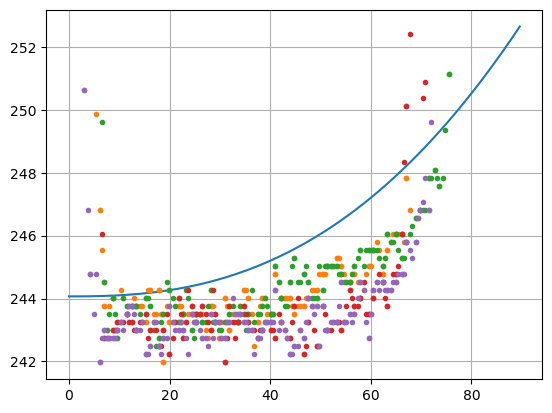

In [54]:
temp_45 = pxl(image_mask(img,255), 45,center, 25, -40 )
temp_135 = pxl(image_mask(img,255), 135,center, 25, -40 )
temp_225 = pxl(image_mask(img,255), 225,center, 25, -40 )
temp_315 = pxl(image_mask(img,255), 315,center, 25, -40 )
k = np.arange(0,90,90/235)
plt.plot(k, modeled_fit['Temp'][:-1]-4.63925357)
plt.plot(temp_45[temp_45[:,0] < 298.3][:,1], temp_45[temp_45[:,0] < 298.3][:,0],'.')
plt.plot(temp_135[temp_135[:,0] < 298.3][:,1], temp_135[temp_135[:,0] < 298.3][:,0],'.')
plt.plot(temp_225[temp_225[:,0] < 298.3][:,1], temp_225[temp_225[:,0] < 298.3][:,0],'.')
plt.plot(temp_315[temp_315[:,0] < 298.3][:,1], temp_315[temp_315[:,0] < 298.3][:,0],'.')
plt.grid()
plt.show()

In [176]:
def sol_scat_distribution(iterate):
    Tem = np.array([])
    r = int(Radius[iterate,0])
#     print(r)
    if r < 235:
        sp = spl_(vza_int,r,0.0)
        sol = float(sp(raa[iterate]))
    else:
        sol = 298.3  
    Tem = np.append(Tem,sol)
    return Tem

# look_up = df_look_up.values
Radius = df_blank[['Radius']].values
# azimuth = df_blank[['raa']].values

vza_int = np.vstack((modeled_fit['Temp'].values, modeled_fit['Temp'].values,\
                     modeled_fit['Temp'].values,modeled_fit['Temp'].values)).T
if __name__ == '__main__':
    pool = Pool(cpu_count())
    res_amb = pool.map(sol_scat_distribution, tqdm(range(0,len(df_blank))))
    pool.close()

100%|██████████| 307200/307200 [00:05<00:00, 54879.72it/s]


In [30]:
Tem = np.array(res_amb)
print(Tem.min())
print(Tem.max())

250.1639692561491
297.29504004524995


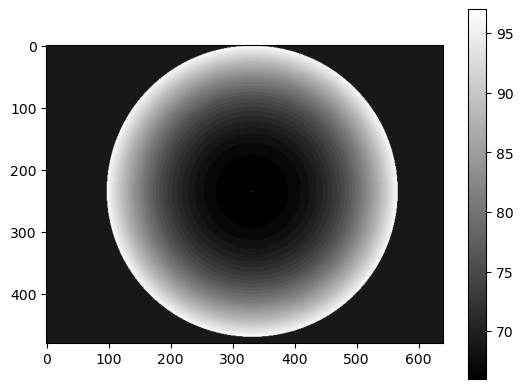

In [177]:
Tem = np.array(res_amb)
# Tem = np.where(Tem==0, 298, Tem) 

# Tmin =Tem.min()
# print(Tem.max())
# print(Tmin)
Tmin = -40 + 273.3
Tmax = 25 + 273.3
# Tmax = Tem.max()
# print(Tmax)

Z_cal = ((Tem) - Tmin)*255/(Tmax-Tmin)
mod = np.uint8(Z_cal.reshape(480,640))

plt.imshow(mod,cmap = 'gray')
plt.colorbar()
plt.show()

In [396]:
# cv.imwrite('cloud_cover/modtran_modeled_img.png',mod)

True

In [178]:
# img = (cv.imread('../Graphs and Images/analysis_0_1/20200415_000001_-10+25_IrImage.jpg',0))

# b,g,r = cv.split(img)           # get b,g,r
# rgb_img = cv.merge([r,g,b])     # switch it to rgb

# # Denoising
# dst = cv.fastNlMeansDenoisingColored(img,None,10,10,7,21)

# b,g,r = cv.split(dst)           # get b,g,r
# rgb_dst = cv.merge([r,g,b])     # switch it to rgb

# gray = cv.cvtColor(rgb_dst,cv.COLOR_BGR2GRAY)
# equ = cv.equalizeHist(gray)


Z_img = img.reshape(-1,1)

img_df = pd.DataFrame({'pxl_img':Z_img[:,0]})
# df_0 = pd.dataFrame({'pxl:', })
df_0 = pd.DataFrame(0, index=range(len(Z_img)), columns={'f_pxl_1'})

masking= pd.merge(img_df,mask,on = img_df.index)

# merged = pd.merge(df_blank, img_df,on = img_df.index)
df_int = masking[masking['contour']< 255]
dataset_plot = pd.merge(df_int, df_0, how='outer', on=None, \
                            left_index=True, right_index=True, sort=True) 
# dataset_plot.head()
df_masked = dataset_plot[['key_0', 'pxl_img','contour']].fillna(255)  
# plt.plot(merged[merged['zenith'] < 90]['zenith'],merged[merged['zenith'] < 90]['pxl_img'],'.')


### Mask modeled
mod = cv.imread('cloud_cover/modtran_modeled_img.png',0)
Z_mod = mod.reshape(-1,1)
img_mod = pd.DataFrame({'pxl_img_mod':Z_mod[:,0]})
# df_0 = pd.dataFrame({'pxl:', })
df_0 = pd.DataFrame(0, index=range(len(df_blank)), columns={'f_pxl_1'})

masking_mod= pd.merge(img_mod,mask,on = img_df.index)

# merged = pd.merge(df_blank, img_df,on = img_df.index)
df_mod_int = masking_mod[masking_mod['contour']< 255]
dataset_plot_mod = pd.merge(df_mod_int, df_0, how='outer', on=None, \
                            left_index=True, right_index=True, sort=True) 
# dataset_plot.head()
df_masked_mod = dataset_plot_mod[['key_0', 'pxl_img_mod','contour']].fillna(255)  

In [33]:
df_DWD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17525 entries, 0 to 17524
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  17525 non-null  datetime64[ns]
 1   CWV       17524 non-null  float64       
 2   dwd_vis   17524 non-null  float64       
 3   Vis       17525 non-null  float64       
 4   AOD       17525 non-null  float64       
 5   Amb_Tem   17524 non-null  float64       
 6   Dew_Tem   17524 non-null  float64       
 7   cloud     17524 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 1.1 MB


In [232]:
# img = (cv.imread('../Graphs and Images/analys_22_23/20200422_225542_-10+25_IrImage.jpg',0))
img = (cv.imread('April2020_Images/Images16_04/20200416_020003_-10+25_IrImage.jpg',0))

mod = cv.imread('cloud_cover/modtran_modeled_img.png',0)

tape = img[231:244,321:349]
Z = tape.reshape(-1,1)
Tmax = 25+273.3 
Tmin = -40+273.3 
c = Tmin
m = (Tmax - Tmin)/255

T = np.mean(m*Z + c)-273.3
print(T)
print(df_DWD[df_DWD.DateTime == '2020-04-16 02:00:00']['Amb_Tem'])
T_amb = df_DWD[df_DWD.DateTime == '2020-04-16 02:00:00']['Amb_Tem'].values
print(T_amb)


bias = pd.read_csv('cloud_cover/bias_night_time_ir.csv')
from sklearn.linear_model import LinearRegression
# print(bias)
x = bias[['T_surf','T_amb']]
y = bias['bias']

linear_regression = LinearRegression()
linear_regression.fit(x,y)

p = np.array([T, T_amb[0]]).reshape(1,2)
offset = linear_regression.predict(p)
# p = np.array([T-273.3, 9.1]).reshape(1,2)

print(offset)

-14.005602240896337
14624    4.9
Name: Amb_Tem, dtype: float64
[4.9]
[-1.11342272]


In [233]:
df_DWD[df_DWD.DateTime == '2020-04-16 02:00:00']

DateTime       CWV  dwd_vis      Vis       AOD  Amb_Tem  \
14624 2020-04-16 02:00:00  1.089423     82.0  40.2335  0.085643      4.9   

       Dew_Tem  cloud  
14624     -0.4    8.0

In [234]:
###### masked = np.uint8(df_masked['pxl_img'].values.reshape(480,640))
masked = (image_mask(img,255))
masked_mod = image_mask(mod,255)

Z_img = masked.reshape(-1,1)
Z_mod = masked_mod.reshape(-1,1)

In [235]:
# Z_img = masked.reshape(-1,1)
# # Z_img = equ.reshape(-1,1)
# # Z_mod = mod_masked.reshape(-1,1)
# Z_mod = masked_mod.reshape(-1,1)

Tmin = -40+273.3
Tmax = 25+273.3
Zmax = 255 
Zmin = 0
c = Tmin

m = (Tmax - Tmin) / (Zmax - Zmin)
T_img = (m*Z_img + c)
T_mod = (m*Z_mod + c)

cloud = 0
pxl = np.zeros((len(T_img),1))
# arr = df_main.values
for  i in range(0,len(T_img)):
    if (T_img[i,0] < 298.3) and (T_mod[i,0] < 298.3):
        if T_img[i,0] > T_mod[i,0]+offset:
            cloud = cloud +1
            pxl[i,0] = T_img[i,0]
    else:
        cloud = cloud + 0
        pxl[i,0] =0

print(cloud/len(T_img[T_img < 298.3])*8)



0.3522900763358779


In [184]:
T_img.shape

(307200, 1)

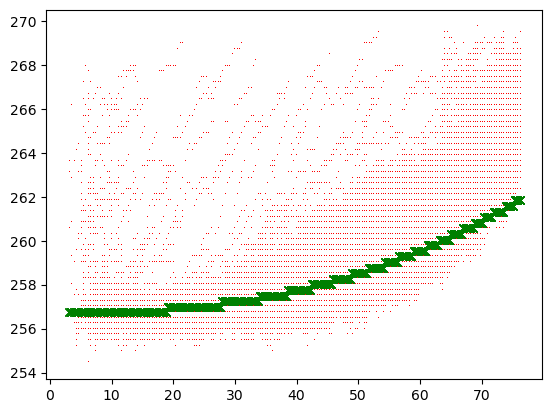

In [3116]:
df_blank['T_img'] = T_img
df_blank['T_mod'] = T_mod
sample = df_blank[df_blank['T_img']<298.3]
plt.plot(sample['zenith'], sample['T_img'],'r,')
plt.plot(sample['zenith'], sample['T_mod']+bias,'gx')
plt.show()

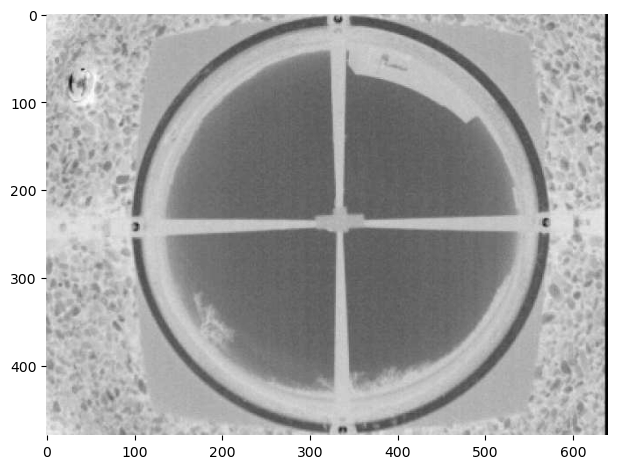

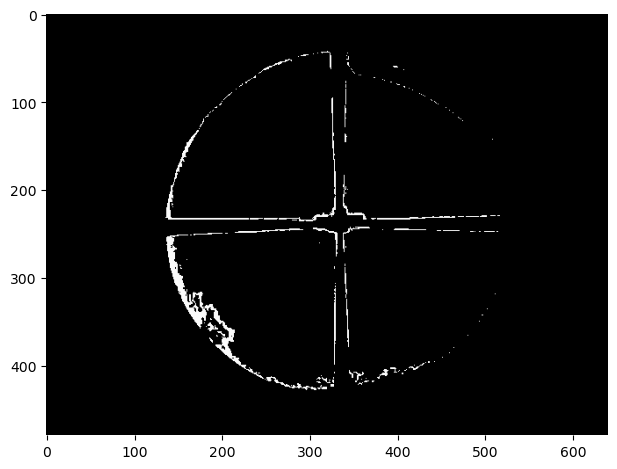

In [236]:
# fig = plt.figure(figsize = (15,6))
# plt.subplot(1,2,1)
plt.imshow(img, cmap = 'gray')
plt.box()
plt.tight_layout()
plt.show()
# plt.subplot(1,2,2)
plt.imshow(pxl.reshape(480, 640), cmap = 'gray')
plt.box()
plt.tight_layout()
plt.show()

In [96]:
df_DWD.info()

day = [16,18,19,20,21]
T_atm = []
for i in day:
    t = df_DWD[df_DWD.DateTime == f'2020-04-{i} 00:00:00']['Amb_Tem'].values + 273.3
    T_atm.append(t)
    
    
def surf_temp(img):
    tape = img[231:244,321:349].reshape(-1,1)
    Tmax = 25
    Tmin = -40
    c = Tmin
    m = (Tmax - Tmin)/255
    T = np.mean(m*tape + c) + 273.3 
    return T

print(str(T_atm[0])+':'+str(200))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17525 entries, 0 to 17524
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  17525 non-null  datetime64[ns]
 1   CWV       17524 non-null  float64       
 2   dwd_vis   17524 non-null  float64       
 3   Vis       17525 non-null  float64       
 4   AOD       17525 non-null  float64       
 5   Amb_Tem   17524 non-null  float64       
 6   Dew_Tem   17524 non-null  float64       
 7   cloud     17524 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 1.1 MB
[279.4]:200


Surface Temp img1: 261.2544817927171
Surface Temp img2: 259.89383753501403
Surface Temp img3: 258.425350140056
Surface Temp img4: 255.04159663865548
Surface Temp img5: 258.63963585434175
Output has Temp,vza
Output has Temp,vza
Output has Temp,vza
Output has Temp,vza
Output has Temp,vza
Output has Temp,vza


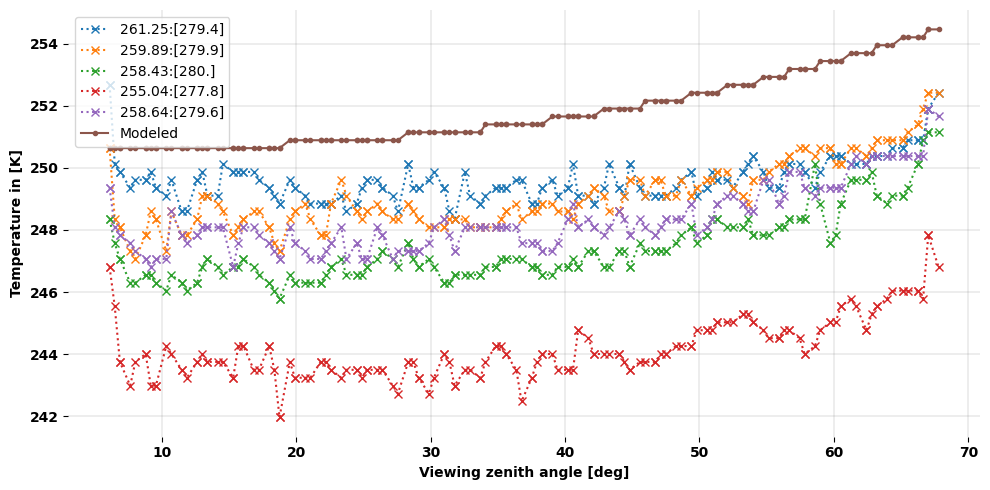

In [99]:
# img = cv.imread('April2020_Images/Images20_04/20200420_000001_-10+25_IrImage.jpg',0)
mod = cv.imread('cloud_cover/modtran_modeled_img.png',0)
img1 = cv.imread('April2020_Images/Images16_04/20200416_000003_-10+25_IrImage.jpg',0)
img2 = cv.imread('April2020_Images/Images18_04/20200418_000002_-10+25_IrImage.jpg',0)
img3 = cv.imread('April2020_Images/Images19_04/20200419_000003_-10+25_IrImage.jpg',0)
img4 = cv.imread('April2020_Images/Images20_04/20200420_000001_-10+25_IrImage.jpg',0)
img5 = cv.imread('April2020_Images/Images21_04/20200421_000001_-10+25_IrImage.jpg',0)
center = np.array([332,235])
theta =np.arange(0,90,90/235)
# temp_img = pxl(image_mask(img,255), 45,center, 25, -40 )



print('Surface Temp img1:',surf_temp(img1))
print('Surface Temp img2:',surf_temp(img2))
print('Surface Temp img3:',surf_temp(img3))
print('Surface Temp img4:',surf_temp(img4))
print('Surface Temp img5:',surf_temp(img5))

mod_img = pxl(image_mask(mod,120), 45,center, 25, -40 )
temp_img1 = pxl(image_mask(img1,120), 45,center, 25, -40 )

temp_img2 = pxl(image_mask(img2,120), 45,center, 25, -40 )
temp_img3 = pxl(image_mask(img3,120), 45,center, 25, -40 )
temp_img4 = pxl(image_mask(img4,120), 45,center, 25, -40 )
temp_img5 = pxl(image_mask(img5,120), 45,center, 25, -40 )


plt.figure(figsize = (10,5))
plt.plot(temp_img1[(temp_img1[:,1]>6)&(temp_img1[:,1]<68)][:,1], \
         temp_img1[(temp_img1[:,1]>6)&(temp_img1[:,1]<68)][:,0],'x:',label = str(round(surf_temp(img1),2))+':'+str(T_atm[0]))    

plt.plot(temp_img2[(temp_img2[:,1]>6)&(temp_img2[:,1]<68)][:,1], \
         temp_img2[(temp_img2[:,1]>6)&(temp_img2[:,1]<68)][:,0],'x:',label = str(round(surf_temp(img2),2))+':'+str(T_atm[1]))

plt.plot(temp_img3[(temp_img3[:,1]>6)&(temp_img3[:,1]<68)][:,1], \
         temp_img3[(temp_img3[:,1]>6)&(temp_img3[:,1]<68)][:,0],'x:',label = str(round(surf_temp(img3),2))+':'+str(T_atm[2]))

plt.plot(temp_img4[(temp_img4[:,1]>6)&(temp_img5[:,1]<68)][:,1], \
         temp_img4[(temp_img4[:,1]>6)&(temp_img5[:,1]<68)][:,0],'x:',label = str(round(surf_temp(img4),2))+':'+str(T_atm[3]))

plt.plot(temp_img5[(temp_img5[:,1]>6)&(temp_img5[:,1]<68)][:,1], \
         temp_img5[(temp_img5[:,1]>6)&(temp_img5[:,1]<68)][:,0],'x:',label = str(round(surf_temp(img5),2))+':'+str(T_atm[4]))

plt.plot(mod_img[(mod_img[:,1]>6)&(mod_img[:,1]<68)][:,1], \
         mod_img[(mod_img[:,1]>6)&(mod_img[:,1]<68)][:,0],'.-',label = 'Modeled')
plt.legend(loc = 'best')

plt.grid(color = 'gray', linewidth = 0.2)
plt.xlabel('Viewing zenith angle [deg]',fontweight = 'bold')
plt.ylabel('Temperature in [K]',fontweight = 'bold')
plt.xticks(fontweight = 'bold')
plt.yticks(fontweight = 'bold')
plt.box()
plt.tight_layout()
plt.show()

In [146]:
print(len(temp_img1[(temp_img1[:,1]>6)&(temp_img1[:,1]<68)][:,0]))
theta = np.arange(0,60,60/163)

163


In [161]:
path = 'April2020_Images/'
category = ['Images15_04','Images16_04','Images17_04','Images18_04',\
           'Images19_04','Images20_04','Images21_04','Images22_04']

T_surface = []
for i in category:
    files = np.sort(glob.glob(path+i+'/*.jpg'))[::720]
    for file in files:
        img = cv.imread(file,0)
        t = surf_temp(img)
        T_surface.append(t)

print(len(np.array(T_surface)[np.array(T_surface) < 298.3]))
print(len(T_amb[T_amb < 298.3]))

192
192


0.9153567363905339 5.4320261950570665e-77


<Figure size 1000x500 with 0 Axes>

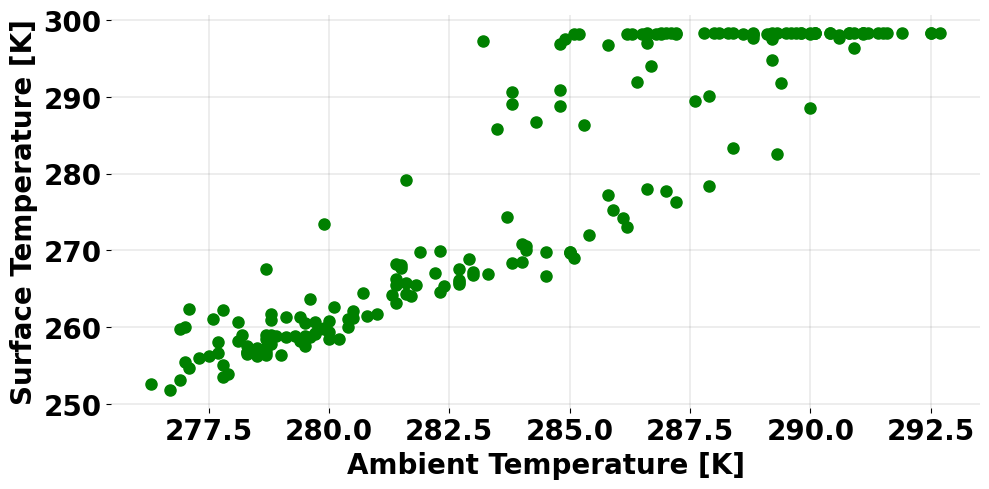

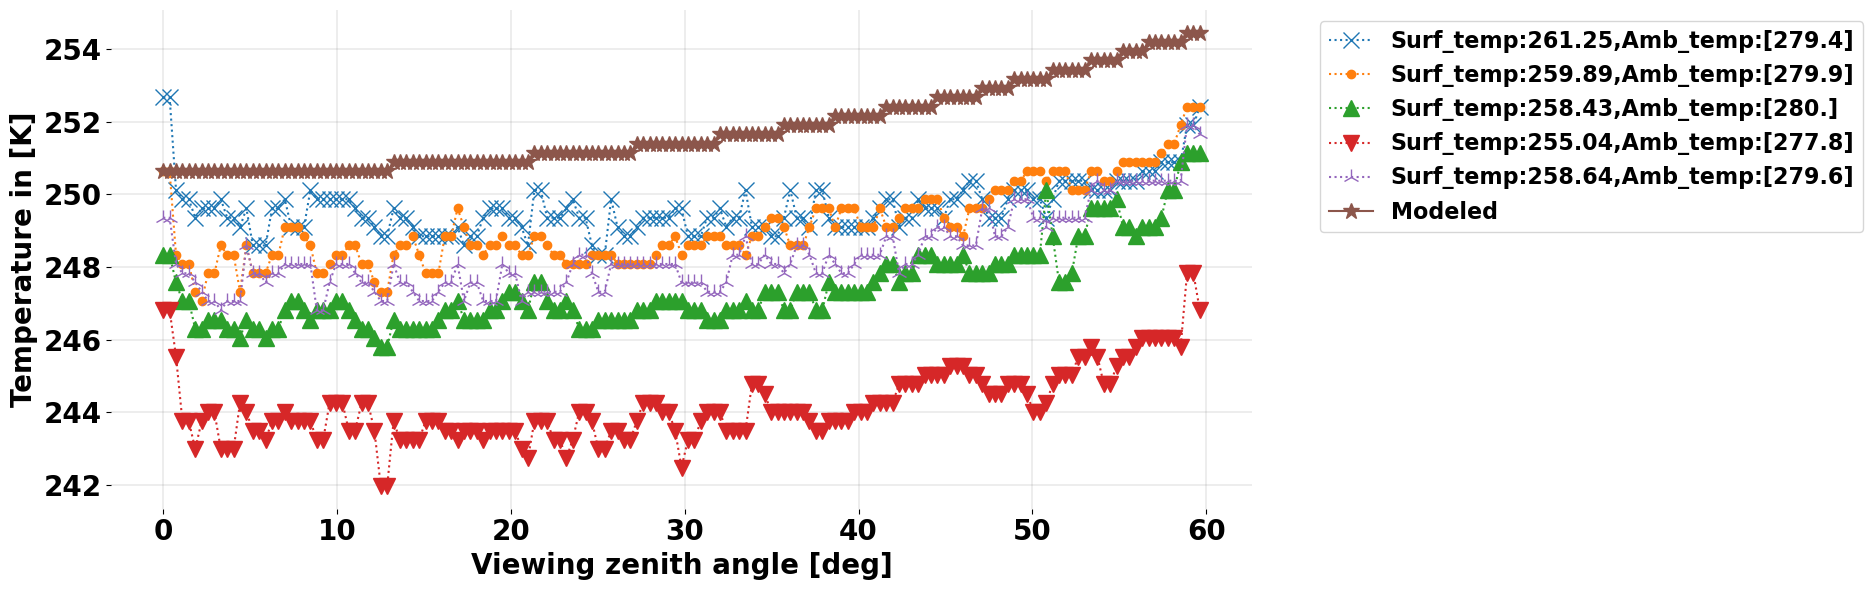

In [162]:
T_amb = df_DWD[(df_DWD.DateTime > '2020-04-14 23:00:00') & (df_DWD.DateTime < '2020-04-23 00:00:00')]['Amb_Tem'].values+273.3
# print(T_amb)
# corr = np.corr(T_amb,T_surface)
from scipy import stats

correlation, p_value = stats.pearsonr(T_amb, T_surface)
print(correlation,p_value)

# fig = plt.figure(figsize= (15,13))

# plt.subplot(2,1,1)
plt.figure(figsize = (10,5))
# plt.plot(T_amb[T_amb < 298.3],T_surface[T_surface < 298.3],'go', markersize = 8)
plt.plot(T_amb[T_amb < 298.3],np.array(T_surface)[np.array(T_surface) < 298.3],'go', markersize = 8)

plt.grid(color= 'gray', linewidth = 0.2)
plt.xlabel('Ambient Temperature [K]', size = 20,fontweight = 'bold')
plt.ylabel('Surface Temperature [K]', size = 20,fontweight = 'bold')
plt.xticks(size = 20,fontweight = 'bold')
plt.yticks(size = 20,fontweight = 'bold')
plt.box()
plt.tight_layout()
plt.show()

# plt.subplot(2,1,2)
plt.figure(figsize = (19,6))
plt.plot(theta,temp_img1[(temp_img1[:,1]>6)&(temp_img1[:,1]<68)][:,0],'x:',\
         markersize = 12,label = 'Surf_temp:'+ str(round(surf_temp(img1),2))+','+'Amb_temp:'+str(T_atm[0]))    

plt.plot(theta,temp_img2[(temp_img2[:,1]>6)&(temp_img2[:,1]<68)][:,0],'.:',\
         markersize = 12,label ='Surf_temp:'+ str(round(surf_temp(img2),2))+','+'Amb_temp:'+str(T_atm[1]))

plt.plot(theta, temp_img3[(temp_img3[:,1]>6)&(temp_img3[:,1]<68)][:,0],'^:',\
         markersize = 12,label ='Surf_temp:'+ str(round(surf_temp(img3),2))+','+'Amb_temp:'+str(T_atm[2]))

plt.plot(theta, temp_img4[(temp_img4[:,1]>6)&(temp_img5[:,1]<68)][:,0],'v:',\
         markersize = 12,label = 'Surf_temp:'+str(round(surf_temp(img4),2))+','+'Amb_temp:'+str(T_atm[3]))

plt.plot(theta, temp_img5[(temp_img5[:,1]>6)&(temp_img5[:,1]<68)][:,0],'2:',\
         markersize = 12,label = 'Surf_temp:'+str(round(surf_temp(img5),2))+','+'Amb_temp:'+str(T_atm[4]))

plt.plot(theta, mod_img[(mod_img[:,1]>6)&(mod_img[:,1]<68)][:,0],'*-',\
         markersize = 12,label = 'Modeled')
plt.legend(loc = 'best',prop = {'size':16,'weight':'bold'},bbox_to_anchor=(1.05, 1))

plt.grid(color = 'gray', linewidth = 0.2)
plt.xlabel('Viewing zenith angle [deg]',size = 20,fontweight = 'bold')
plt.ylabel('Temperature in [K]',size = 20,fontweight = 'bold')
plt.xticks(fontweight = 'bold',size = 20)
plt.yticks(fontweight = 'bold',size = 20)
plt.box()
plt.tight_layout()
plt.show()


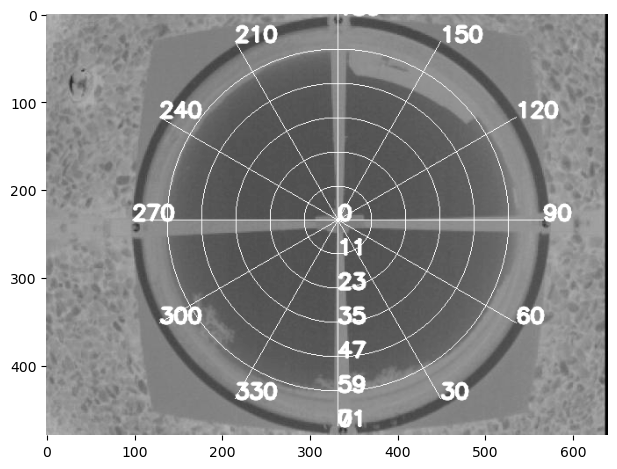

In [103]:
################################
# This function creates the grid on an image to represent vza and raa on an image. 
# Input: 1. image, on which the grid needs to be created
#        2. dist = radius( 235 for IR and 240 for color)
#        3. number of steps in azimuth direction, eg, steps = 12, then the lines 
#           will be created at an interval of 30deg
#        4. viewing zenith angle
#        5. vza_step, same as az_step
#        6. center of an image. In out case the center is at [332,235]

# def image_grid(image,dist,az_step,vza,vza_step,center):

# plt.imshow(image_grid(image_mask(img,255),235,12,np.arange(0,72,72/235),5,[332,235]),cmap = 'gray')
plt.imshow(image_grid(img,235,12,np.arange(0,72,72/235),6,[332,235]),cmap = 'gray')
plt.box()
plt.tight_layout()
plt.show()

In [3029]:
df_DWD[df_DWD.DateTime =='2020-04-15 09:00:00']

DateTime       CWV  dwd_vis      Vis       AOD  Amb_Tem  \
2526 2020-04-15 09:00:00  1.179915     82.0  40.2335  0.085643      8.3   

      Dew_Tem  cloud  
2526      0.9    6.0

### Cloud detection algorithm implementation 

In [168]:
# linear_regression.score(x,y)
y_pred = np.array([])
for i in range(0,len(x)):
    t = np.array([x.values[i,0], x.values[i,1]]).reshape(1,2)
    y_ = linear_regression.predict(t)
    y_pred = np.append(y_pred,y_)
    
    
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
#     mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
#     print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
    
regression_results(y.values, y_pred)

explained_variance:  0.9633
r2:  0.9633
MAE:  0.8721
MSE:  1.2796
RMSE:  1.1312


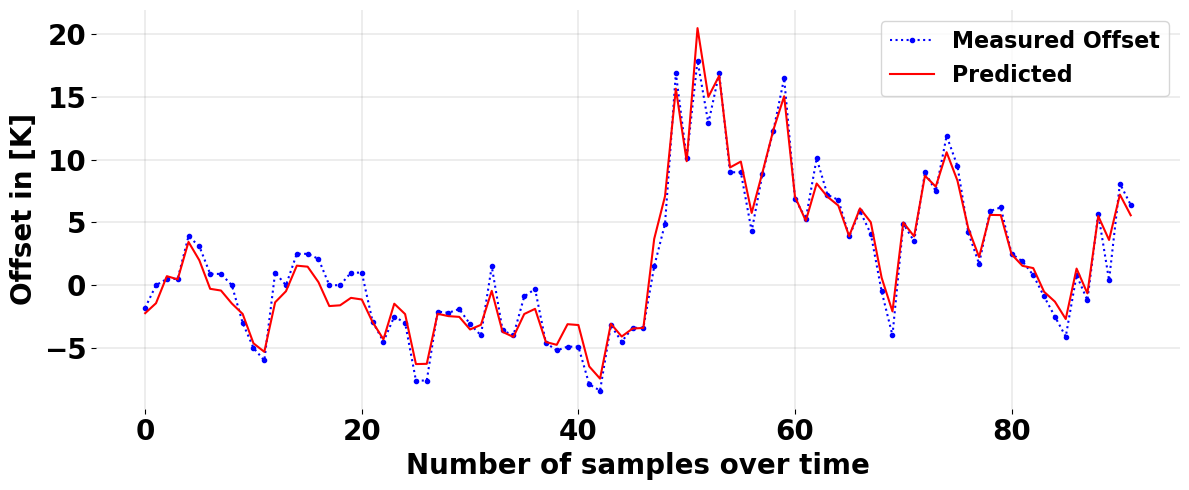

In [169]:
plt.figure(figsize = (12,5))

plt.plot(y.values,'b.:',label = 'Measured Offset')
plt.plot(y_pred,'r',label = 'Predicted')
plt.legend(loc = 'best',prop = {'size':16,'weight':'bold'})

plt.grid(color = 'gray', linewidth = 0.2)
plt.xlabel('Number of samples over time',size = 20,fontweight = 'bold')
plt.ylabel('Offset in [K]',size = 20,fontweight = 'bold')
plt.xticks(fontweight = 'bold',size = 20)
plt.yticks(fontweight = 'bold',size = 20)
plt.box()
plt.tight_layout()
plt.show()

In [170]:
def sol_scat_distribution(iterate):
        Tem = np.array([])
        r = int(Radius[iterate,0])
        if r < 235:
            sp = spl_(vza_int,r,0.0)
            sol = float(sp(raa[iterate,0]))
        else:
            sol = 0    
        Tem = np.append(Tem,sol)
        return Tem

In [2972]:
path = 'April2020_Images/'
category = ['Images15_04','Images16_04','Images17_04','Images18_04',\
           'Images19_04','Images20_04','Images21_04','Images22_04']


def sol_scat_distribution(iterate):
        Tem = np.array([])
        r = int(Radius[iterate,0])
        if r < 235:
            sp = spl_(vza_int,r,0.0)
            sol = float(sp(raa[iterate,0]))
        else:
            sol = 0    
        Tem = np.append(Tem,sol)
        return Tem
mod = cv.imread('cloud_cover/modtran_modeled_img.png',0)

timestamp = []
cld_coverage = []
dwd_cld_coverage = []
surf_temp= []
T_ambient = []
for i in category:
#     files = np.sort(glob.glob(path+i+'/*.jpg'))[::120] ## Every 10 min 
    files = np.sort(glob.glob(path+i+'/*.jpg'))[::60]
#     print(files)
    for file in files:
#         print(file)
#         time = np.datetime64(im_timestamp_sig(file))
        hour = pd.Timestamp(im_timestamp_sig(file)).hour
        day = pd.Timestamp(im_timestamp_sig(file)).day
        mint = pd.Timestamp(im_timestamp_sig(file)).minute
        
#         cloud_dwd = df_DWD[df_DWD['DateTime'] == f'2020-04-{day} {hour}:00:00']['cloud'].values
        
        
#         if (hour <7) | (hour > 19):
        img = cv.imread(file,0)
        tape = img[231:244,321:349]
        
        
        Z = tape.reshape(-1,1)
        Tmax = 25+273.3 
        Tmin = -40+273.3 
        c = Tmin
        m = (Tmax - Tmin)/255

        T = np.mean(m*Z + c) 

        if hour == 23 and mint > 30:
            day = day+1
            hour = 0
        elif hour!= 23 and mint > 30:
            hour = hour +1
#         gray = cv.cvtColor(img_denoised, cv.COLOR_BGR2GRAY)
        ### Image masking
        """
        below applied 55 deg horizon mask
        """
        masked = image_mask(img,255)

        time = im_timestamp_sig(file)
        cloud_dwd = df_DWD[df_DWD['DateTime'] == f'2020-04-{day} {hour}:00:00']['cloud'].values
        T_amb = df_DWD[df_DWD['DateTime'] == f'2020-04-{day} {hour}:00:00']['Amb_Tem'].values 
#             print(T-273.3, T_amb[0])
        p = np.array([T-273.3, T_amb[0]]).reshape(1,2)
        bias = linear_regression.predict(p)

        ### Applying mask on the modeled image
#         """
#         below applied 55 deg horizon mask
#         """
        mod_masked = image_mask(mod,255)

        #### Conversion of pxl intensity to temperature

        Z_img = masked.reshape(-1,1)
        # Z_img = equ.reshape(-1,1)
        Z_mod = mod_masked.reshape(-1,1)
        T_img = (m*Z_img + c)
        T_mod = (m*Z_mod + c)
#             print(T_img.max(),T_mod.max())
#             print(T_img.min(),T_mod.min())
        cld_pxl = 0
        pxl = np.zeros((len(T_img),1))
        for  j in range(0,len(T_img)):
            if (T_img[j,0] < 298.3) and (T_mod[j,0] < 298.3):
                if T_img[j,0] > T_mod[j,0]+bias:
                    cld_pxl = cld_pxl +1 
                    pxl[j,0] = T_img[j,0]
                else:
                    cld_pxl = cld_pxl + 0
                    pxl[j,0] = 0
        coverage = (cld_pxl/len(T_img[T_img < 298.3]))*8

        timestamp.append(time)
        cld_coverage.append(coverage)
        dwd_cld_coverage.append(int(cloud_dwd[0]))
        surf_temp.append(T)
        T_ambient.append(T_amb[0])
#             break
#         break 
#     break

In [2134]:
# cld_coverage
# T_ambient

[5.99236641221374]

In [2974]:
# df_IR_nigh_time = pd.DataFrame({'DateTime':timestamp,'cloud_img':cld_coverage,'cloud_dwd':dwd_cld_coverage,\
#                                'T_surf':surf_temp,'T_amb':T_ambient})

# # df_IR_nigh_time['T_amb'] = df_IR_nigh_time['T_amb']+273.3
# error = df_IR_nigh_time['cloud_img']-df_IR_nigh_time['cloud_dwd']

df_IR = pd.DataFrame({'DateTime':timestamp,'cloud_img':cld_coverage,'cloud_dwd':dwd_cld_coverage,\
                               'T_surf':surf_temp,'T_amb':T_ambient})
df_IR['error'] = df_IR['cloud_img']-df_IR['cloud_dwd']

df_weather = df_DWD[(df_DWD.DateTime > '2020-04-14 23:00:00') &(df_DWD.DateTime < '2020-04-23 00:00:00')]

In [2979]:
# df_IR.head(5)

In [2975]:
# df_IR = pd.DataFrame({'DateTime':timestamp,'cloud_img':cld_coverage,'cloud_dwd':dwd_cld_coverage})
# df_IR.to_csv('cloud_cover/cloud_coverage_IR_final_5min.csv', header = True, index = False)
# df_color = pd.read_csv('cloud_cover/color_cloud_cover.csv')
df_color['DateTime']= pd.to_datetime(df_color['DateTime'])

# df_weather = df_IR[['DateTime','cloud_dwd']]

In [2976]:
# df_color['DateTime'] = df_color['DateTime']  - pd.Timedelta(hours=2)
df_color['DateTime'] = df_color['DateTime']  + pd.Timedelta(hours=1) 


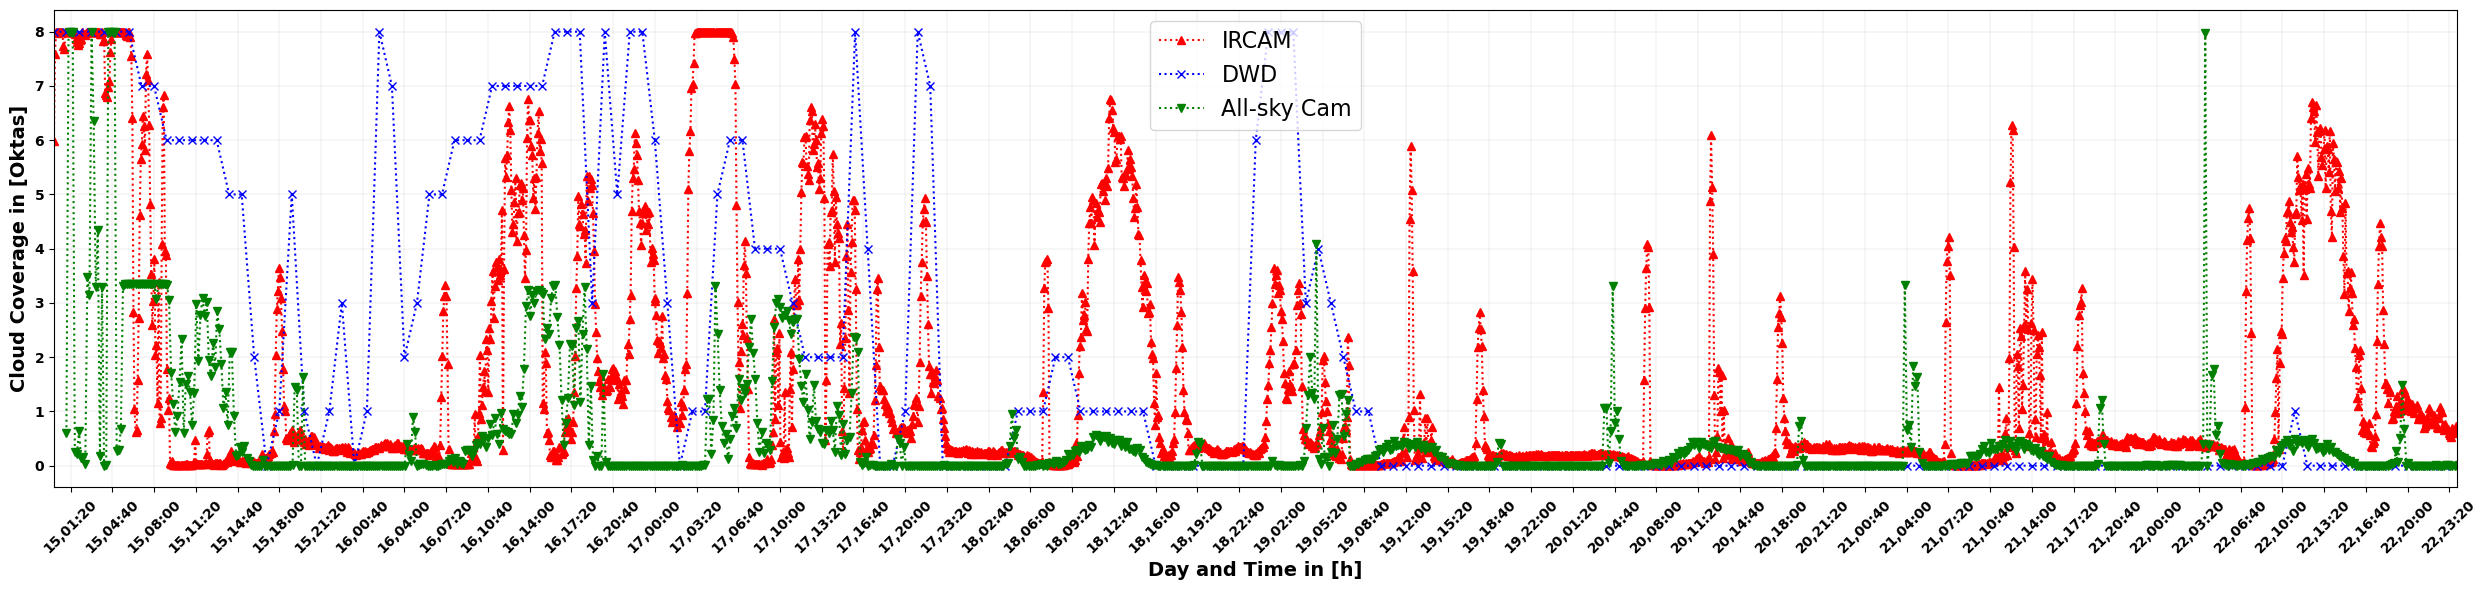

In [2977]:
import matplotlib.dates as dates
import matplotlib.dates as mdates
plt.figure(figsize = (25,6))
plt.plot(df_IR['DateTime'],df_IR['cloud_img'],'r^:',label = 'IRCAM')
# plt.plot(df_IR['DateTime'],df_IR['cloud_dwd'],'b^:',label = 'DWD')
plt.plot(df_weather['DateTime'],df_weather['cloud'],'bx:',label = 'DWD')
plt.plot(df_color['DateTime'],df_color['cloud_col'],'gv:',label = 'All-sky Cam')
# plt.plot(night_time['DateTime'][0::3],night_time['cloud_dwd'][0::3],'bx:')
#plt.plot(night_time['DateTime'],night_time['error'],'x:')
plt.legend(loc = 'best', prop={'size': 16})
xax = plt.gca().get_xaxis()
# format major xtick label
xax.set_major_locator(mdates.MinuteLocator(interval=200)) 
xax.set_major_formatter(dates.DateFormatter('%d,%H:%M'))
# plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.xticks(fontweight = 'bold',rotation = 45)

plt.xlim(df_IR['DateTime'].iloc[0],df_IR['DateTime'].iloc[-1])

plt.yticks(fontweight = 'bold')
plt.grid(color = 'gray', linewidth = 0.1)
plt.xlabel('Day and Time in [h]',fontweight = 'bold', size = 14)
plt.ylabel('Cloud Coverage in [Oktas]',fontweight = 'bold', size = 14)
plt.tight_layout()
plt.show()

#### Surface temperature and ambient temperature 

In [3083]:
path = 'April2020_Images/'
category = ['Images15_04','Images16_04','Images17_04','Images18_04',\
           'Images19_04','Images20_04','Images21_04','Images22_04']

Time = []
surf_temp = []
for i in category:
#     files = np.sort(glob.glob(path+i+'/*.jpg'))[::120] ## Every 10 min 
    files = np.sort(glob.glob(path+i+'/*.jpg'))[::60]
#     print(files)
    for file in files:
#         print(file)
        time = np.datetime64(im_timestamp_sig(file))
#         hour = pd.Timestamp(im_timestamp_sig(file)).hour
#         day = pd.Timestamp(im_timestamp_sig(file)).day
#         mint = pd.Timestamp(im_timestamp_sig(file)).minute
        
        img = cv.imread(file,0)
        tape = img[231:244,321:349]
        Z = tape.reshape(-1,1)
        Tmax = 25+273.3 
        Tmin = -40+273.3 
        c = Tmin
        m = (Tmax - Tmin)/255

        T = np.mean(m*Z + c) 
        
        Time.append(time)
        surf_temp.append(T)

In [3084]:
df = pd.DataFrame({'DateTime':Time, 'Surf_Tem': surf_temp})


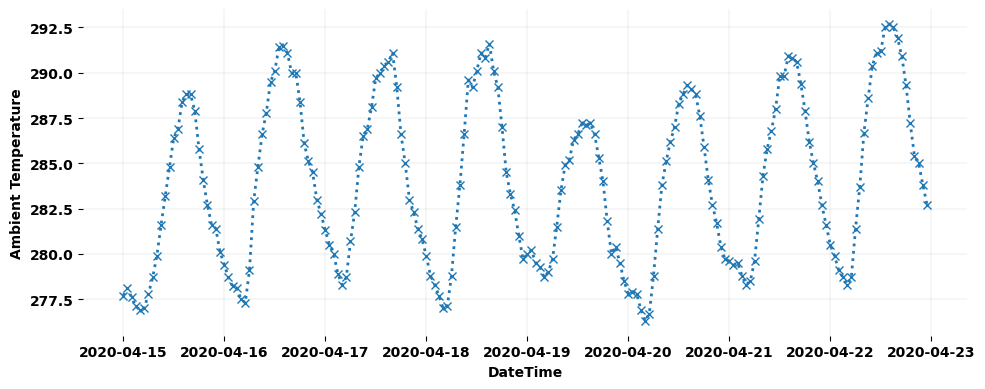

In [3101]:
plt.figure(figsize = (10,4))
# plt.plot(df['DateTime'], df['Surf_Tem'],'.:')
plt.plot(df_weather['DateTime'],df_weather['Amb_Tem']+273.3,'x:', linewidth = 2)
plt.xlabel('DateTime', fontweight = 'bold')
plt.ylabel('Ambient Temperature', fontweight = 'bold')
plt.xticks(fontweight = 'bold')
plt.yticks(fontweight = 'bold')
plt.grid(color = 'gray', linewidth = 0.1)
plt.tight_layout()
plt.box()
plt.show()